# Fourier transforms
*27 Jan 2020*

This should be a simple notebook: we will just take the Fourier transform of a 2d image.

In [25]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from scipy import fftpack

Now we still need an image...

In [3]:
from helpers import CustomImage

In [4]:
# Simple image:
zl = 0.2
xs = [0,2]
ys = [10,-2]
redshifts = [.2,.25]

In [5]:
# Now we'll try something more intense
np.random.seed(123)

zl = 0.2
xs, ys, redshifts = [], [], []
for i in range(20):
    xs.append( np.random.uniform(-15,15) )
    ys.append( np.random.uniform(-15,15) )
    redshifts.append( np.random.uniform(0,1) ) 

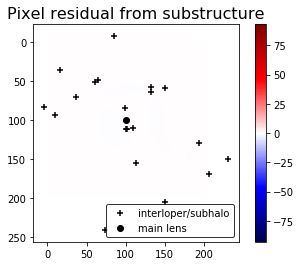

In [6]:
blankimg = CustomImage([],[],[], zl=zl)

myimg = CustomImage(xs, ys, redshifts, zl=zl, m=1e7)

vmin = np.min(myimg.image - blankimg.image)
vmax = np.max(myimg.image - blankimg.image)
vmin = min(vmin, -vmax)
vmax = max(vmax, -vmin)

plt.imshow(myimg.image - blankimg.image, vmin=vmin, vmax=vmax, cmap='seismic')
plt.colorbar()
plt.scatter([myimg.x_to_pix(x,z) for x,z in zip(xs, redshifts)],
            [myimg.x_to_pix(y,z) for y,z in zip(ys, redshifts)], color='black', marker='+', label='interloper/subhalo')
plt.scatter([myimg.x_to_pix(0)], [myimg.x_to_pix(0)], color='black', label='main lens')

leg = plt.legend()
#leg.get_frame().set_linewidth(3)
leg.get_frame().set_edgecolor('k')

plt.title('Pixel residual from substructure', size=16)

plt.show()

In [7]:
divmat, curlmat = myimg.calc_div_curl()

In [8]:
divmat_blank, curlmat_blank = blankimg.calc_div_curl()

The image is:

In [9]:
#image = divmat

In [10]:
image = (divmat - divmat_blank).T

In [11]:
def autoshow(image, vmax=None):
    if vmax == None:
        vmin = np.min(image)
        vmax = np.max(image)
        vmin = min(vmin, -vmax)
        vmax = max(vmax, -vmin)
    else:
        vmin = -vmax

    ext=20
    plt.imshow(image, vmin=vmin, vmax=vmax, cmap='seismic', extent=[-ext,ext,ext,-ext])
    plt.colorbar()
    #plt.show()

Text(0.5, 1.0, '$\\kappa_\\mathrm{eff}$')

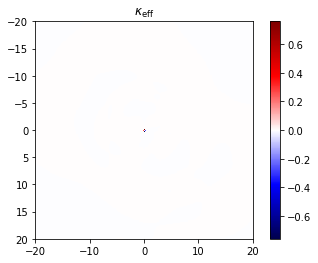

In [12]:
autoshow(image)#, vmax=.003)
plt.title(r'$\kappa_\mathrm{eff}$')
#plt.savefig('imgs/jan27_full.png')

In [13]:
#sorted(abs(inner_image.flatten()), reverse=True)

In [14]:
npix = 2

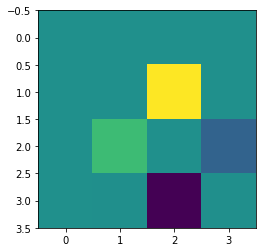

In [15]:
plt.imshow(image[100-npix:100+npix,100-npix:100+npix])

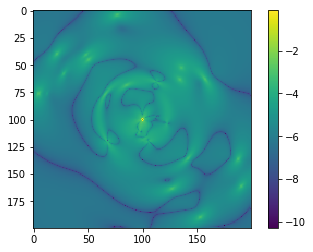

In [16]:
plt.imshow(np.log10(abs(image)))
plt.colorbar()

Text(0.5, 1.0, '$\\kappa_\\mathrm{eff}$ without 4x4 center pixels')

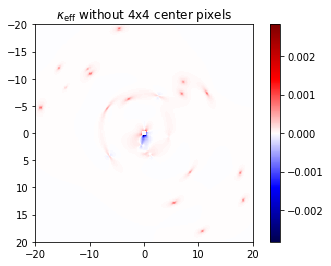

In [17]:
outer_image = np.copy(image)
for i in range(100-npix,100+npix):
    for j in range(100-npix,100+npix):
        outer_image[i,j] = 0

autoshow(outer_image)
plt.title(r'$\kappa_\mathrm{eff}$ without 4x4 center pixels')
#plt.savefig('imgs/jan27_outer.png')

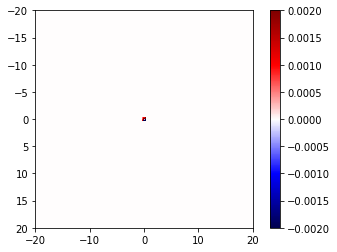

In [18]:
inner_image = np.zeros((200,200))
for i in range(100-npix,100+npix):
    for j in range(100-npix,100+npix):
        inner_image[i,j] = image[i,j]

autoshow(inner_image, vmax=.002)

## Tutorial
Hey look at [this link](https://www.astrobetter.com/blog/2010/03/03/fourier-transforms-of-images-in-python/)! It's perfect!

Text(0.5, 1.0, 'fft: $\\kappa_\\mathrm{eff}$')

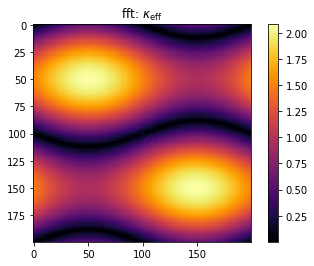

In [385]:
F1 = fftpack.fft2(image)
F2 = fftpack.fftshift(F1)
plt.imshow(abs(F2), cmap='inferno')
plt.colorbar()
plt.title(r'fft: $\kappa_\mathrm{eff}$')
#plt.savefig('imgs/jan27_fft_full.png')

In [ ]:
F1 = fftpack.fft2(inner_image)
F2 = fftpack.fftshift(F1)
plt.imshow(np.abs(F2), cmap='inferno')
plt.colorbar()

Text(0.5, 1.0, 'fft: $\\kappa_\\mathrm{eff}$ without 4x4 center pixels')

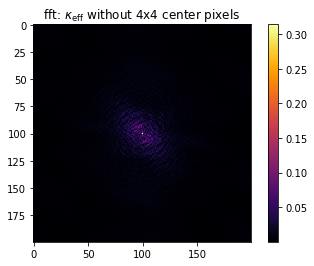

In [389]:
F1 = fftpack.fft2(outer_image)
F2 = fftpack.fftshift(F1)
plt.imshow(abs(F2), cmap='inferno')
plt.colorbar()
plt.title(r'fft: $\kappa_\mathrm{eff}$ without 4x4 center pixels')
#plt.savefig('imgs/jan27_fft_outer.png')

Text(0.5, 1.0, 'log10 fft: $\\kappa_\\mathrm{eff}$ without 4x4 center pixels')

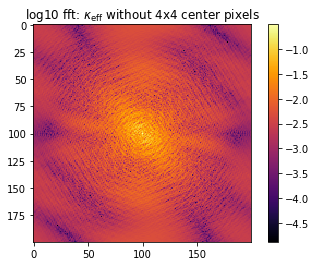

In [390]:
plt.imshow(np.log10(abs(F2)), cmap='inferno')
plt.colorbar()
plt.title('log10 fft: $\kappa_\mathrm{eff}$ without 4x4 center pixels')

Text(0.5, 1.0, 'fft angle: $\\kappa_\\mathrm{eff}$ without 4x4 center pixels')

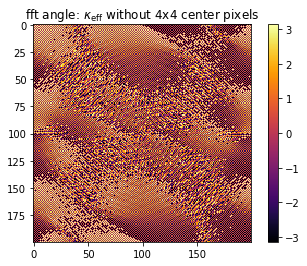

In [391]:
plt.imshow(np.angle(F2), cmap='inferno')
plt.colorbar()
plt.title('fft angle: $\kappa_\mathrm{eff}$ without 4x4 center pixels')

In [392]:
ps2d = np.abs(F2)**2

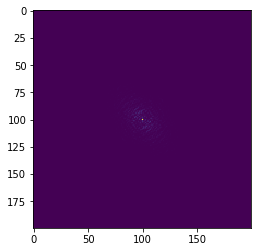

In [393]:
plt.imshow(ps2d)

In [394]:
def azimuthalAverage(image, center=None):
    """
    (from https://www.astrobetter.com/wiki/tiki-index.php?page=python_radial_profiles)
    
    Calculate the azimuthally averaged radial profile.

    image - The 2D image
    center - The [x,y] pixel coordinates used as the center. The default is 
             None, which then uses the center of the image (including 
             fracitonal pixels).
    
    """
    # Calculate the indices from the image
    y, x = np.indices(image.shape)

    if not center:
        center = np.array([(x.max()-x.min())/2.0, (x.max()-x.min())/2.0])

    r = np.hypot(x - center[0], y - center[1])

    # Get sorted radii
    ind = np.argsort(r.flat)
    r_sorted = r.flat[ind]
    i_sorted = image.flat[ind]

    # Get the integer part of the radii (bin size = 1)
    r_int = r_sorted.astype(int)

    # Find all pixels that fall within each radial bin.
    deltar = r_int[1:] - r_int[:-1]  # Assumes all radii represented
    rind = np.where(deltar)[0]       # location of changed radius
    nr = rind[1:] - rind[:-1]        # number of radius bin
    
    # Cumulative sum to figure out sums for each radius bin
    csim = np.cumsum(i_sorted, dtype=float)
    tbin = csim[rind[1:]] - csim[rind[:-1]]

    radial_prof = tbin / nr

    return radial_prof

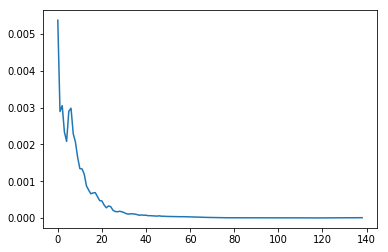

In [395]:
plt.plot(azimuthalAverage(ps2d))
#plt.savefig('imgs/jan27_ps_2int.png')

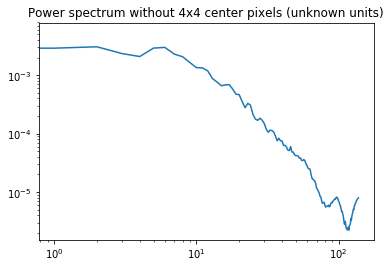

In [399]:
plt.loglog(azimuthalAverage(ps2d))
plt.title('Power spectrum without 4x4 center pixels (unknown units)')
plt.savefig('imgs/jan27_outer_ps.png')

Hmm, but how do we compare this with our actual units?

More basic stuff:

In [188]:
from numpy.fft import fft

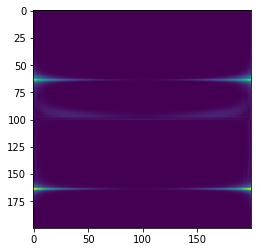

In [189]:
plt.imshow(abs(fft(image)))

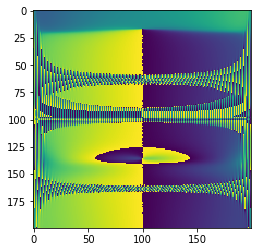

In [190]:
plt.imshow(np.angle(fft(image)))

In [168]:
from numpy.fft import fftshift

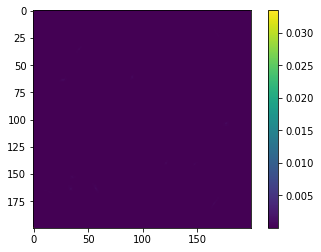

In [169]:
plt.imshow(abs(fftshift(image)));
plt.colorbar()
plt.show()

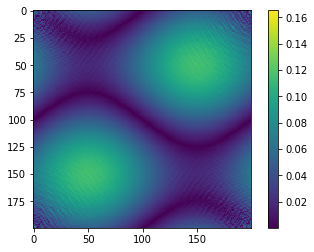

In [170]:
plt.imshow(abs(fft2(image)));
plt.colorbar()
plt.show()

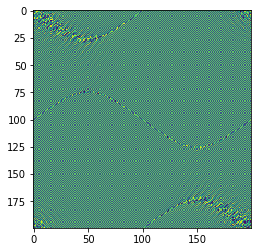

In [171]:
plt.imshow(np.angle(fft2(image)))

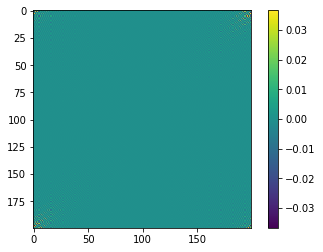

In [35]:
plt.imshow(np.imag(fft2(image))); plt.colorbar()

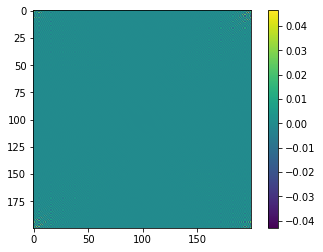

In [37]:
plt.imshow(np.real(fft2(image))); plt.colorbar()

## Using Ana's code

In [19]:
np.save('files/outer_image.npy', outer_image)

In [27]:
!python2 --version

Python 2.7.13


In [28]:
myimg.pixnum * myimg.pixsize # arcsec

40.0

In [31]:
# Calculate physical size of the image
distance = 845000 # kpc
angle = 40 * np.pi/648000 # rad

In [32]:
angle * distance # kpc

163.86702421502315

In [44]:
myimg.pixnum

200

In [46]:
!python2 make_mask.py --pix_num=200 --side=164

In [72]:
!python2 power_spectrum.py \
--conv_file1 files/outer_image.npy \
--kdir files/ \
--psdir files/ \
--pix_num 200 \
--side 164 \
--name testDM \
# --z 0.2 \
# --m_high 1e-2 \
# --m_low 1e-4 \
--num_proj 1 \
--sigma_crit 3.14e9

convergence maps loaded:
files/outer_image.npy
k saved in files/ktestDM_095_200_164.txt
saved files/ind_curves_testDM_095_200_164


In [73]:
klist = np.loadtxt('files/ktestDM_095_200_164.txt')
plist = np.load('files/ind_curves_testDM_095_200_164.npy')

In [74]:
len(plist[0])

98

In [75]:
len(klist)

98

Text(0, 0.5, 'Power (kpc^2)')

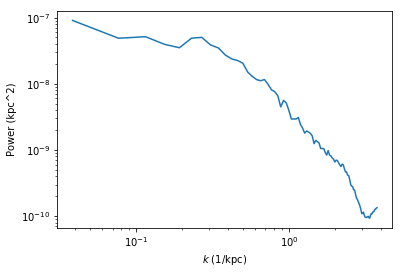

In [76]:
plt.loglog(klist, plist[0])
plt.xlabel(r'$k$ (1/kpc)')
plt.ylabel(r'Power (kpc^2)')